# Tutorial: Differentiable Information Imbalance (JAX implementation)

The Differentiable Information Imbalance (DII) is a tool to automatically learn the optimal distance function A to predict close pair of points in a target distance space B. 

This notebook shows a brief tutorial of the JAX implementation of the DII, available in the 'DiffImbalance' class. For more information, please refer to the diff_imbalance module in the DADApy documentation: https://dadapy.readthedocs.io/en/latest/modules.html

In [ ]:
from dadapy import DiffImbalance
import matplotlib.pyplot as plt
import numpy as np
import os
import jax

jax.config.update("jax_platform_name", "cpu")  # can run on 'cpu' or 'gpu'; restart the
# notebook kernel to make this change effective
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # avoid jax memory preallocation

In [2]:
%load_ext autoreload
%autoreload 2

## Optimization on a 5D anisotropic Gaussian dataset

The differentiable Information Imbalance is computed here as
\begin{equation}
DII(d^A(\boldsymbol{w})\rightarrow B) = \frac{2}{N^2} \sum_{i,j=1}^N\, c_{ij}^A\, r_{ij}^B\, \hspace{1cm} \Bigg( c_{ij}^A = \frac{\exp(-d_{ij}^A(\boldsymbol{w})^2/\lambda)}{\sum_{k(\neq i)}{\exp(-d_{ik}^A(\boldsymbol{w})^2/\lambda)}}\Bigg).
\end{equation}
Qualitatively, parameter $\lambda$ decides how many neighbors are considered - for very small $\lambda$, only the neigherest neighbor receives a weight of $~1$, and all other neighbors receive weights close to $0$.

In this example we show how to assign the optimal weights $\boldsymbol{w} = \{w_\alpha\}$ to the features $\{X_\alpha\}$ $(\alpha=1,...,D)$, which define space A, in order to optimize the prediction of distances in a target space B. We will construct space A using a 5-dimensional isotropic Gaussian distribution, and space B by reweighting its coordinates, resulting in a 5-dimensional anisotropic Gaussian.

The weights appear in the distance function as
\begin{equation}
d_{ij}^A(\boldsymbol{w}) = \Bigg[\sum_{\alpha=1}^D\,(w_{\alpha}X_\alpha^i - w_{\alpha}X_\alpha^j)^2 \Bigg]^{1/2},
\end{equation}
and they are optimized by gradient descent.

In [ ]:
# generate test data
weights_ground_truth = np.array([10, 3, 1, 30, 7.3])
np.random.seed(0)
data_A = np.random.normal(loc=0, scale=1.0, size=(500, 5))  # sample 500 points
data_B = weights_ground_truth[np.newaxis, :] * data_A

# train the DII to recover ground-truth metric
dii = DiffImbalance(
    data_A=data_A,  # matrix of shape (N,D_A)
    data_B=data_B,  # matrix of shape (N,D_B)
    distances_B=None,  # space B can also be given as a distance matrix (N,N)
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=500,
    batches_per_epoch=1,  # no mini-batches
    l1_strength=0.0,  # no l1 regularization
    point_adapt_lambda=True,
    k_init=1,
    k_final=1,
    params_init=None,  # automatically set to [0.1,0.1,0.1,0.1,0.1]
    params_groups=None,
    optimizer_name="sgd",  # possible choices: "sgd", "adam", "adamw"
    learning_rate=1e-2,
    learning_rate_decay=None,  # possible choices: None, "cos", "exp"
    num_points_rows=None,
    gradient_clip_value=0.0,  # no gradient clipping
)
weights, imbs = dii.train()

print(f"Ground truth weights = {weights_ground_truth}\n")
# scale learnt weights in same range of ground-truth ones (same magnitude of the largest one)
print(
    f"Learnt weights: {np.abs(weights[-1]) / (np.max(np.abs(weights[-1])) / np.max(weights_ground_truth))}"
)

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Ground truth weights = [10.   3.   1.  30.   7.3]

Learnt weights: [ 9.99  2.95  0.89 30.    7.31]


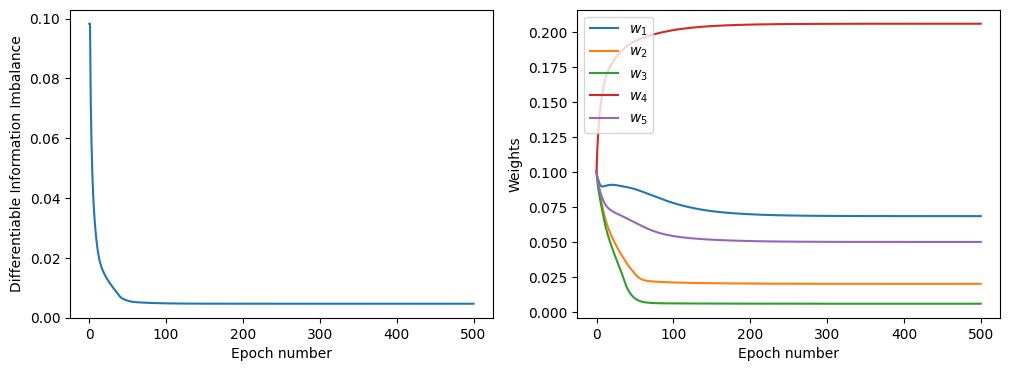

In [4]:
# plot the DII and the weights during the training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(imbs)
ax2.plot(weights[:, 0], label="$w_1$")
ax2.plot(weights[:, 1], label="$w_2$")
ax2.plot(weights[:, 2], label="$w_3$")
ax2.plot(weights[:, 3], label="$w_4$")
ax2.plot(weights[:, 4], label="$w_5$")

ax1.set(ylabel="Differentiable Information Imbalance", xlabel="Epoch number")
ax2.set(ylabel="Weights", xlabel="Epoch number")
ax2.legend()
plt.show()

The plots above show the convergence of the DII (left panel) and of the feature weights (right panel) as a function of the epoch number.

In this simple example we employed no decay schedule for the learning rate (argument 'learning_rate_decay'), although possible options are 'cos' (cosine decay) and 'exp' (learning rate is halved every 10 epochs). Although these schedules avoid "overshooting" the minimum and can improve the optimization of the DII, we suggest to always perform a first optimization in absence of any learning rate decay schedule, to verify that the number of epoches (argument 'num_epochs') is appropriate to ensure convergence.

In particularly noisy data sets, strategies to speed up and improve the DII optimization include the use of mini-batches (argument 'batches_per_epoch') coupled with more sophisticated optimizers (e.g. 'adam'), and the use of a larger neighborhood size for setting the parameter $\lambda$ adaptively (arguments 'k_init' and 'k_final').
Viable options are setting 'batches_per_epoch' such that each mini-batch contains ~100 points, and setting 'k_init' and 'k_final' such that ~5% of the points are included in each neighborhood. For example, if the original data set contains $N=500$ points, setting 'batches_per_epoch' to 5 results in mini-batches of $N'=100$ points each, and setting 'k_init' and 'k_final' to 5 allows selecting 5% of the points in each mini-batch:

In [5]:
# train the DII to recover ground-truth metric
dii = DiffImbalance(
    data_A=data_A,  # matrix of shape (N,D_A)
    data_B=data_B,  # matrix of shape (N,D_B)
    distances_B=None,
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=500,
    batches_per_epoch=5,  # no mini-batches
    l1_strength=0.0,  # no l1 regularization
    point_adapt_lambda=True,
    k_init=5,
    k_final=5,
    params_init=None,  # automatically set to [0.1,0.1,0.1,0.1,0.1]
    params_groups=None,
    optimizer_name="adam",  # possible choices: "sgd", "adam", "adamw"
    learning_rate=1e-2,
    learning_rate_decay="cos",  # possible choices: None, "cos", "exp"
    num_points_rows=None,
    gradient_clip_value=0.0,  # no gradient clipping
)
weights, imbs = dii.train()  # the outputs can also be accessed after training
# with dii.params_training and dii.imbs_training

print(f"Ground truth weights = {weights_ground_truth}\n")

# scale learnt weights in same range of ground-truth ones (same magnitude of the largest one)
print(
    f"Learnt weights: {np.abs(weights[-1]) / (np.max(np.abs(weights[-1])) / np.max(weights_ground_truth))}"
)

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Ground truth weights = [10.   3.   1.  30.   7.3]

Learnt weights: [10.04  2.86  0.57 30.    7.3 ]


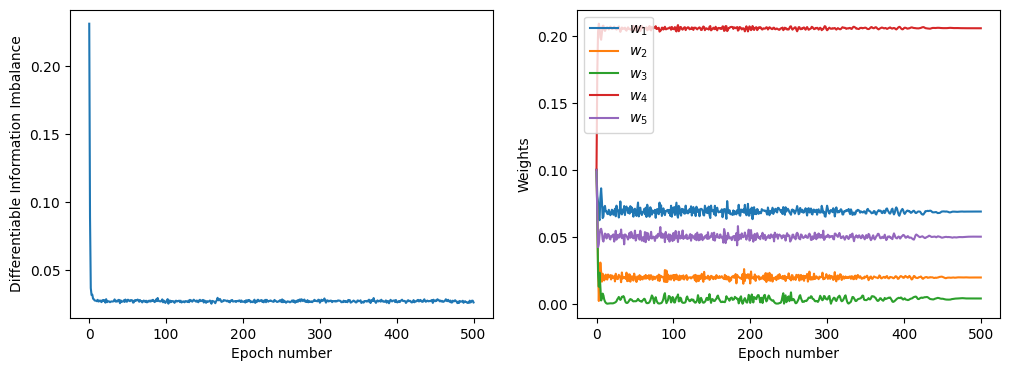

In [6]:
# plot the DII and the weights during the training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(imbs)
ax2.plot(weights[:, 0], label="$w_1$")
ax2.plot(weights[:, 1], label="$w_2$")
ax2.plot(weights[:, 2], label="$w_3$")
ax2.plot(weights[:, 3], label="$w_4$")
ax2.plot(weights[:, 4], label="$w_5$")

ax1.set(ylabel="Differentiable Information Imbalance", xlabel="Epoch number")
ax2.set(ylabel="Weights", xlabel="Epoch number")
ax2.legend()
plt.show()

In this case, the panel on the left depicts the DII computed, at each training epoch, over the last mini-batch employed in that epoch.
The DII can be computed on the full data set after convergence using the method 'return_final_dii'. For details on its arguments refer to the DADApy documentation: https://dadapy.readthedocs.io/en/latest/modules.html.

In [7]:
imb_final, _ = dii.return_final_dii(
    compute_error=False, ratio_rows_columns=None, seed=0, discard_close_ind=0
)
print(f"Optimal DII over full data set: {imb_final:2f}")  # can also be accessed
# through dii.imb_final

Optimal DII over full data set: 0.011225


## Greedy Feature Search: Forward Search Implementation

Feature selection can be achieved either by optimizing the DII with a L1 regularization, or with a _greedy_ search approach. We show in this section how to run a "forward" _greedy_ search, where we first identify the optimal single feature and successively add features one by one to get the optimal n-tuple feature sets.
The process is called  "_greedy_" because it does not explore every possible combination of features, since that would be computationally untenable for high-dimensional datasets.

The parameter `n_best` controls the _greediness_ of the algorithm. If `n_best` is set to 1, the optimal n-tuple is identified by adding one feature at a time to the optimal (n-1)-tuple (by only adding features that are not already contained in this (n-1)-tuple). The candidate n-tuples are optimized according to the DII, and the one providing the lowest DII is selected for the next step. If `n_best` is not 1, the optimal n-tuple is identified by adding one feature at a time to the optimal `n_best` tuples of size (n-1), resulting in a broader exploration of the search space at the price of an increased runtime.

In the following example, we use the same 5-dimensional Gaussian of the previous tests, with ground-trith weights [10, 3, 1, 30, 7.3]. Hence, the optimal n-tuples for each value of n should be:
- n=1 -> [3]
- n=2 -> [0, 3]
- n=3 -> [0, 3, 4]
- n=4 -> [0, 1, 3, 4]
- n=5 -> [0, 1, 2, 3, 4]

The "forward" _greedy_ search is the recommended approach to use when one is looking to select few relevant features (compared to the total possible number of features).

In [8]:
# initialize DII object
dii = DiffImbalance(
    data_A,
    data_B,
    distances_B=None,
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=50,
    batches_per_epoch=5,
    l1_strength=0.0,
    point_adapt_lambda=True,
    k_init=5,
    k_final=5,
    lambda_factor=1e-1,
    params_init=None,
    params_groups=None,
    optimizer_name="sgd",
    learning_rate=1e-1,
    learning_rate_decay="cos",
    num_points_rows=None,
    gradient_clip_value=0.0,  # no gradient clipping
)

In [9]:
# forward greedy search
(
    feature_sets_fw,
    diis_fw,
    errors_fw,
    weights_fw,
) = dii.forward_greedy_feature_selection(
    n_features_max=5,
    n_best=10,
    compute_error=True,
    ratio_rows_columns=1,
    seed=0,
    discard_close_ind=0,
)

diis_fw_array = np.array(diis_fw)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0], DII = 0.8999369144439697



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1], DII = 0.9869815111160278



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2], DII = 0.9980540871620178



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [3], DII = 0.24966953694820404



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [4], DII = 0.9708154797554016

------------------------------------------------
Best single feature: [3]
	DII: 0.24966953694820404
	Optimal weights: [0.  0.  0.  0.1 0. ]
Selected 5 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 3], DII = 0.09266918152570724



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 3], DII = 0.23949241638183594



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2, 3], DII = 0.2464694380760193



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [3, 4], DII = 0.17840220034122467



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1], DII = 0.8793095946311951



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2], DII = 0.8978637456893921



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 4], DII = 0.8358938097953796



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 4], DII = 0.9284020662307739



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2, 4], DII = 0.965335488319397



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2], DII = 0.9652043581008911



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 3]: [0.04 0.   0.   0.13 0.  ]

------------------------------------------------
Best 2-tuple: [0, 3]
	DII: 0.09266918152570724
	Optimal weights: [0.04 0.   0.   0.13 0.  ]
Selected 10 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 3], DII = 0.07906471192836761



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2, 3], DII = 0.09181760251522064



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 3, 4], DII = 0.025932028889656067



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 3, 4], DII = 0.16652920842170715



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2, 3, 4], DII = 0.1782713383436203



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2, 3], DII = 0.23630225658416748



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 4], DII = 0.8256107568740845



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2, 4], DII = 0.8346009850502014



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2], DII = 0.873705267906189



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2, 4], DII = 0.9206231832504272



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 3, 4]: [0.05 0.   0.   0.16 0.04]

------------------------------------------------
Best 3-tuple: [0, 3, 4]
	DII: 0.025932028889656067
	Optimal weights: [0.05 0.   0.   0.16 0.04]
Selected 10 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 3, 4], DII = 0.02279951237142086



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2, 3, 4], DII = 0.02593725360929966



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2, 3], DII = 0.07835109531879425



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2, 3, 4], DII = 0.16602429747581482



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2, 4], DII = 0.8103418350219727



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 1, 3, 4]: [0.06 0.02 0.   0.18 0.05]

------------------------------------------------
Best 4-tuple: [0, 1, 3, 4]
	DII: 0.02279951237142086
	Optimal weights: [0.06 0.02 0.   0.18 0.05]
Selected 5 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2, 3, 4], DII = 0.02285277657210827



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 1, 2, 3, 4]: [0.07 0.02 0.   0.21 0.05]

------------------------------------------------
Best 5-tuple: [0, 1, 2, 3, 4]
	DII: 0.02285277657210827
	Optimal weights: [0.07 0.02 0.   0.21 0.05]
Selected 1 best candidates for next iteration
------------------------------------------------


In [10]:
print(f"\nSelected feature subsets:\n {feature_sets_fw}\n")
print("Forward DIIs:", diis_fw)
print("Forward Errors:", errors_fw)
print("Forward Weights:", weights_fw)

print("\nOriginal weights:", weights_ground_truth)
print(
    f"\nLearnt weights for the full feature space: {np.abs(weights_fw[-1]) / (np.max(np.abs(weights_fw[-1])) / np.max(weights_ground_truth))}"
)
print(
    f"\nAll weights along the feature selection:\n {np.abs(weights_fw) / (np.max(np.abs(weights_fw)) / np.max(weights_ground_truth))}"
)


Selected feature subsets:
 [[3], [0, 3], [0, 3, 4], [0, 1, 3, 4], [0, 1, 2, 3, 4]]

Forward DIIs: [0.24966953694820404, 0.09266918152570724, 0.025932028889656067, 0.02279951237142086, 0.02285277657210827]
Forward Errors: [0.007513740565627813, 0.005023834761232138, 0.000543437257874757, 0.0003448267816565931, 0.0003450679068919271]
Forward Weights: [array([0. , 0. , 0. , 0.1, 0. ]), array([0.04, 0.  , 0.  , 0.13, 0.  ], dtype=float32), array([0.05, 0.  , 0.  , 0.16, 0.04], dtype=float32), array([0.06, 0.02, 0.  , 0.18, 0.05], dtype=float32), array([0.07, 0.02, 0.  , 0.21, 0.05], dtype=float32)]

Original weights: [10.   3.   1.  30.   7.3]

Learnt weights for the full feature space: [10.16  2.78  0.59 30.    7.39]

All weights along the feature selection:
 [[ 0.    0.    0.   14.6   0.  ]
 [ 6.27  0.    0.   19.68  0.  ]
 [ 7.88  0.    0.   23.32  5.82]
 [ 9.09  2.48  0.   26.84  6.63]
 [10.16  2.78  0.59 30.    7.39]]


## Greedy Feature Search: Backward Search Implementation

Here we implement the "backward" _greedy_ search approach, starting with all the features and then successively removing features one by one to get the most optimal n-plet feature sets.
As in the "forward" _greedy_ search implementation, the parameter `n_best` controls the _greediness_ of the algorithm. If `n_best` is set to 1, the optimal n-tuple is identified by removing one feature at a time to the optimal (n+1)-tuple (by only adding features that are not already contained in this (n+1)-tuple). The candidate n-tuples are optimized according to the DII, and the one providing the lowest DII is selected for the next step. If `n_best` is not 1, the optimal n-tuple is identified by removing one feature at a time to the `n_best` optimal tuples of size (n+1).

In the following example, the optimal n-plets for each value of n should be:
- n=5 -> [0, 1, 2, 3, 4]
- n=4 -> [0, 1, 3, 4]
- n=3 -> [0, 3, 4]
- n=2 -> [0, 3]
- n=1 -> [3]

The "backward" _greedy_ search is the recommended approach to use when one is looking to select a significant number of relevant features (compared to the total possible number of features), or a case where one just wants to eliminate a few uninformative features.

In [11]:
# initialize DII object and train over full feature space
dii = DiffImbalance(
    data_A,
    data_B,
    distances_B=None,
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=50,
    batches_per_epoch=5,
    l1_strength=0.0,
    point_adapt_lambda=True,
    k_init=5,
    k_final=5,
    lambda_factor=1e-1,
    params_init=None,
    params_groups=None,
    optimizer_name="sgd",
    learning_rate=1e-1,
    learning_rate_decay="cos",
    num_points_rows=None,
    gradient_clip_value=0.0,  # no gradient clipping
)
weights, imbs = dii.train()

Training:   0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
# forward greedy selection
(
    feature_sets_bw,
    diis_bw,
    errors_bw,
    weights_bw,
) = dii.backward_greedy_feature_selection(
    n_features_min=1,
    n_best=10,
    compute_error=True,
    ratio_rows_columns=1,
    seed=0,
    discard_close_ind=0,
)

diis_bw_array = np.array(diis_bw)

------------------------------------------------
All features: [[0, 1, 2, 3, 4]]
	DII: 0.02281881496310234
	Optimal weights: [0.07 0.02 0.   0.21 0.05]
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2, 3, 4], DII = 0.16650478541851044



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2, 3, 4], DII = 0.02593725360929966



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 3, 4], DII = 0.022799985483288765



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2, 4], DII = 0.8162417411804199



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2, 3], DII = 0.07873981446027756



Training:   0%|          | 0/50 [00:00<?, ?it/s]

------------------------------------------------
Best 4-tuple: [0, 1, 3, 4]
	DII: 0.022799985483288765
	Optimal weights: [0.06 0.02 0.   0.18 0.05]
Selected 5 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 3, 4], DII = 0.16643910109996796



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 3, 4], DII = 0.02594284899532795



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 4], DII = 0.8212908506393433



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 3], DII = 0.0785510316491127



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2, 3, 4], DII = 0.1782713383436203



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2, 4], DII = 0.8310080766677856



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2, 3], DII = 0.09189017117023468



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2, 3], DII = 0.23976528644561768



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2], DII = 0.873705267906189



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2, 4], DII = 0.9206231832504272



Training:   0%|          | 0/50 [00:00<?, ?it/s]

------------------------------------------------
Best 3-tuple: [0, 3, 4]
	DII: 0.02594284899532795
	Optimal weights: [0.05 0.   0.   0.16 0.04]
Selected 10 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [3, 4], DII = 0.1784670203924179



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 4], DII = 0.8345729112625122



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 3], DII = 0.09218078851699829



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 3], DII = 0.2390100210905075



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1], DII = 0.8793095946311951



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2, 3], DII = 0.24899360537528992



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2], DII = 0.8961151838302612



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 4], DII = 0.9284020662307739



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2, 4], DII = 0.965335488319397



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2], DII = 0.9652043581008911



Training:   0%|          | 0/50 [00:00<?, ?it/s]

------------------------------------------------
Best 2-tuple: [0, 3]
	DII: 0.09218078851699829
	Optimal weights: [0.04 0.   0.   0.13 0.  ]
Selected 10 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [3], DII = 0.24966953694820404



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0], DII = 0.8999369144439697



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [4], DII = 0.9708154797554016



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1], DII = 0.9869815111160278



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2], DII = 0.9980540871620178



Training:   0%|          | 0/50 [00:00<?, ?it/s]

------------------------------------------------
Best 1-tuple: [3]
	DII: 0.24966953694820404
	Optimal weights: [0.  0.  0.  0.1 0. ]
Selected 5 best candidates for next iteration
------------------------------------------------


In [13]:
print(f"\nSelected feature subsets:\n {feature_sets_bw}\n")

print("Backward DIIs:", diis_bw)
print("Backward Errors:", errors_bw)
print("Backward Weights:", weights_bw)

print("\nOriginal weights:", weights_ground_truth)
print(
    f"\nLearnt weights for the full feature space: {np.abs(weights_bw[0]) / (np.max(np.abs(weights_bw[0])) / np.max(weights_ground_truth))}"
)
print(
    f"\nAll weights along the feature selection:\n {np.abs(weights_bw) / (np.max(np.abs(weights_bw)) / np.max(weights_ground_truth))}"
)


Selected feature subsets:
 [[0, 1, 2, 3, 4], [0, 1, 3, 4], [0, 3, 4], [0, 3], [3]]

Backward DIIs: [0.02281881496310234, 0.022799985, 0.025942849, 0.09218079, 0.24966954]
Backward Errors: [0.00034392185625620186, 0.00034475446, 0.0005474836, 0.004991478, 0.0075137406]
Backward Weights: [Array([0.07, 0.02, 0.  , 0.21, 0.05], dtype=float32), Array([0.06, 0.02, 0.  , 0.18, 0.05], dtype=float32), Array([0.05, 0.  , 0.  , 0.16, 0.04], dtype=float32), Array([0.04, 0.  , 0.  , 0.13, 0.  ], dtype=float32), Array([0. , 0. , 0. , 0.1, 0. ], dtype=float32)]

Original weights: [10.   3.   1.  30.   7.3]

Learnt weights for the full feature space: [10.16  2.78  0.59 30.    7.39]

All weights along the feature selection:
 [[10.16  2.78  0.59 30.    7.39]
 [ 9.09  2.48  0.   26.84  6.63]
 [ 7.88  0.    0.   23.32  5.82]
 [ 6.27  0.    0.   19.68  0.  ]
 [ 0.    0.    0.   14.6   0.  ]]


## Greedy Feature Search: Forward Search Implementation with random initial parameters

Sometimes it can be beneficial to use random or specific initial parameters. In this minimal working example, we show how to reproduce the forward search results from before with random initial values.

In [ ]:
# Create random initialization parameters between 0.1 and 5
np.random.seed(42)  # Different seed for initialization
random_params_init = np.random.uniform(0.1, 1.0, size=5)
print(f"Random initialization parameters: {random_params_init}")

# initialize DII object
dii = DiffImbalance(
    data_A,
    data_B,
    distances_B=None,
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=50,
    batches_per_epoch=5,
    l1_strength=0.0,
    point_adapt_lambda=True,
    k_init=5,
    k_final=5,
    lambda_factor=1e-1,
    params_init=random_params_init,
    params_groups=None,
    optimizer_name="sgd",
    learning_rate=1e-1,
    learning_rate_decay="cos",
    num_points_rows=None,
    gradient_clip_value=0.0,  # no gradient clipping
)

Random initialization parameters: [0.44 0.96 0.76 0.64 0.24]


In [16]:
# forward greedy search
(
    feature_sets_fw,
    diis_fw,
    errors_fw,
    weights_fw,
) = dii.forward_greedy_feature_selection(
    n_features_max=5,
    n_best=10,
    compute_error=True,
    ratio_rows_columns=1,
    seed=0,
    discard_close_ind=0,
)

diis_fw_array = np.array(diis_fw)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0], DII = 0.8999369144439697



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1], DII = 0.9869815111160278



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2], DII = 0.9980540871620178



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [3], DII = 0.24966953694820404



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [4], DII = 0.9708154201507568

------------------------------------------------
Best single feature: [3]
	DII: 0.24966953694820404
	Optimal weights: [0.   0.   0.   0.64 0.  ]
Selected 5 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 3], DII = 0.09253114461898804



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 3], DII = 0.24575760960578918



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2, 3], DII = 0.24920889735221863



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [3, 4], DII = 0.17840951681137085



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1], DII = 0.8937233686447144



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2], DII = 0.8912479877471924



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 4], DII = 0.8237865567207336



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 4], DII = 0.9258096218109131



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2, 4], DII = 0.9624024033546448



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2], DII = 0.9577182531356812



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 3]: [0.24 0.   0.   0.74 0.  ]

------------------------------------------------
Best 2-tuple: [0, 3]
	DII: 0.09253114461898804
	Optimal weights: [0.24 0.   0.   0.74 0.  ]
Selected 10 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 3], DII = 0.07906686514616013



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2, 3], DII = 0.09201338142156601



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 3, 4], DII = 0.025917546823620796



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 3, 4], DII = 0.17142511904239655



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [2, 3, 4], DII = 0.1797252595424652



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2, 3], DII = 0.2425578385591507



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 4], DII = 0.8260566592216492



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2, 4], DII = 0.8407187461853027



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2], DII = 0.8776196241378784



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2, 4], DII = 0.9209155440330505



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 3, 4]: [0.25 0.   0.   0.75 0.18]

------------------------------------------------
Best 3-tuple: [0, 3, 4]
	DII: 0.025917546823620796
	Optimal weights: [0.25 0.   0.   0.75 0.18]
Selected 10 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 3, 4], DII = 0.0226767435669899



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 2, 3, 4], DII = 0.025871505960822105



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2, 3], DII = 0.08024432510137558



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [1, 2, 3, 4], DII = 0.17095157504081726



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2, 4], DII = 0.8203752636909485



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 1, 3, 4]: [0.42 0.12 0.   1.13 0.3 ]

------------------------------------------------
Best 4-tuple: [0, 1, 3, 4]
	DII: 0.0226767435669899
	Optimal weights: [0.42 0.12 0.   1.13 0.3 ]
Selected 5 best candidates for next iteration
------------------------------------------------


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Feature set = [0, 1, 2, 3, 4], DII = 0.022924069315195084



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 1, 2, 3, 4]: [0.51 0.16 0.05 1.31 0.37]

------------------------------------------------
Best 5-tuple: [0, 1, 2, 3, 4]
	DII: 0.022924069315195084
	Optimal weights: [0.51 0.16 0.05 1.31 0.37]
Selected 1 best candidates for next iteration
------------------------------------------------


In [17]:
print(f"\nSelected feature subsets:\n {feature_sets_fw}\n")
print("Forward DIIs:", diis_fw)
print("Forward Errors:", errors_fw)
print("Forward Weights:", weights_fw)

print("\nOriginal weights:", weights_ground_truth)
print(
    f"\nLearnt weights for the full feature space: {np.abs(weights_fw[-1]) / (np.max(np.abs(weights_fw[-1])) / np.max(weights_ground_truth))}"
)
print(
    f"\nAll weights along the feature selection:\n {np.abs(weights_fw) / (np.max(np.abs(weights_fw)) / np.max(weights_ground_truth))}"
)


Selected feature subsets:
 [[3], [0, 3], [0, 3, 4], [0, 1, 3, 4], [0, 1, 2, 3, 4]]

Forward DIIs: [0.24966953694820404, 0.09253114461898804, 0.025917546823620796, 0.0226767435669899, 0.022924069315195084]
Forward Errors: [0.007513740565627813, 0.005027309525758028, 0.0005451009492389858, 0.00034249896998517215, 0.00035094129270873964]
Forward Weights: [array([0.  , 0.  , 0.  , 0.64, 0.  ]), array([0.24, 0.  , 0.  , 0.74, 0.  ], dtype=float32), array([0.25, 0.  , 0.  , 0.75, 0.18], dtype=float32), array([0.42, 0.12, 0.  , 1.13, 0.3 ], dtype=float32), array([0.51, 0.16, 0.05, 1.31, 0.37], dtype=float32)]

Original weights: [10.   3.   1.  30.   7.3]

Learnt weights for the full feature space: [11.76  3.73  1.15 30.    8.41]

All weights along the feature selection:
 [[ 0.    0.    0.   14.62  0.  ]
 [ 5.4   0.    0.   16.87  0.  ]
 [ 5.76  0.    0.   17.13  4.18]
 [ 9.71  2.8   0.   25.92  6.96]
 [11.76  3.73  1.15 30.    8.41]]
